In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, auc, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.svm import SVC
from time import time

In [2]:
# Read new dataset
df = pd.read_csv('model_dataset_att2.csv')
df

,ID,seniority_level,desc_clean
0,1,Mid-Senior level,company descriptionthe ikigai platform unlocks...
1,4,Mid-Senior level,job title : engineerlocation : remotewho we ar...
2,21,Mid-Senior level,about usnational grid is hiring a senior data ...
3,22,Mid-Senior level,about usnational grid is hiring a senior data ...
4,23,Mid-Senior level,about usnational grid is hiring a senior data ...
...,...,...,...
736,965,Junior level,what is aviture ? aviture is a full-service te...
737,976,Junior level,location : us remotejob summarywe are seeking ...
738,980,Junior level,responsibilitiesthe business risk integrated c...
739,981,Junior level,location : us remotejob summarywe are seeking ...


In [3]:
%%markdown
# TF-IDF Vectorization
Just like in the notebook 'Iteration_1' I start with several iterations of SKLearn's `TfidfVectorizer`. 
Compared to the previous version there is one difference in the settings: I do not set a value for the parameter `max_df`. 
The reason for this is that in the notebook 'EDA_sequel' I removed all bigrams and unigrams which appeared frequently in both types of vacancies.<br> 
Thus, my assumption is that if a bigram/unigram occurs a lot in one type of vacancy, it will not appear a lot in another type of vacancy. 
My expectation is that the model will have more predictive power by not putting a limit on the amount of vacancies bigrams and unigrams can appear in.  

After vectorisation, I do a PCA with two components and then I plot them to see whether there is much distance between junior level vacancies and senior level vacancies.
##### Result
Ultimately there is not much of a difference between the plots of the iterations of the vectorisation (with the parameter `min_df` ranging from 4 to 9). 
Therefore I set `min_df` at 4.

# TF-IDF Vectorization
Just like in the notebook 'Iteration_1' I start with several iterations of SKLearn's `TfidfVectorizer`. 
Compared to the previous version there is one difference in the settings: I do not set a value for the parameter `max_df`. 
The reason for this is that in the notebook 'EDA_sequel' I removed all bigrams and unigrams which appeared frequently in both types of vacancies.<br> 
Thus, my assumption is that if a bigram/unigram occurs a lot in one type of vacancy, it will not appear a lot in another type of vacancy. 
My expectation is that the model will have more predictive power by not putting a limit on the amount of vacancies bigrams and unigrams can appear in.  

After vectorisation, I do a PCA with two components and then I plot them to see whether there is much distance between junior level vacancies and senior level vacancies.
##### Result
Ultimately there is not much of a difference between the plots of the iterations of the vectorisation (with the parameter `min_df` ranging from 4 to 9). 
Therefore I set `min_df` at 4.


In [4]:
# function to perform PCA on output of TfidfVectorizer
def to_be_named(min_df):
    
    vectorizer = TfidfVectorizer(stop_words = 'english', sublinear_tf = True, ngram_range = (1,2), norm = 'l2', min_df = min_df)
    features = vectorizer.fit_transform(df.desc_clean).toarray()

    print("dimensions are {}".format(np.shape(features)))

    pca = PCA(n_components=2)
    pca_fitted = pca.fit(features.T)

    pca_df = pd.DataFrame(pca_fitted.components_.T, columns=['comp1', 'comp2'])
    plot_set = pd.merge(df, pca_df, left_index = True, right_index = True)
    
    ax_I = sns.scatterplot(data=plot_set, x="comp1", y="comp2", hue="seniority_level")
    ax_I.set(title = 'Component plot, min_df is {}'.format(i))
    plt.show()
    
    vectorizer 

In [5]:
min_df_list = [4,5,6,7,8,9]
#max_df_list = [40,50,60]

dimensions are (741, 18492)


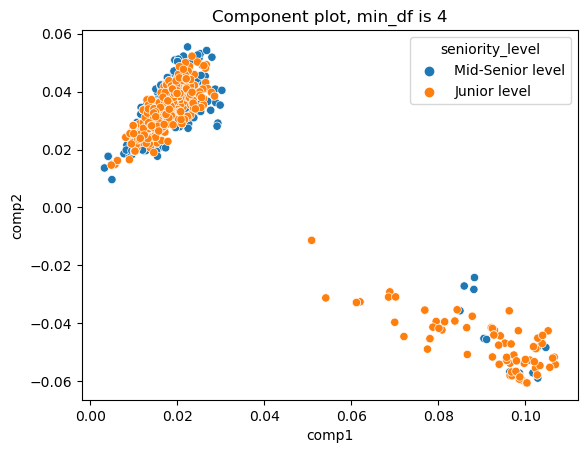

dimensions are (741, 14257)


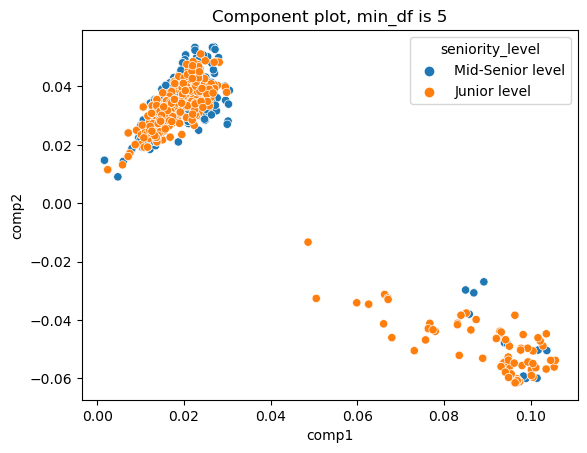

dimensions are (741, 10948)


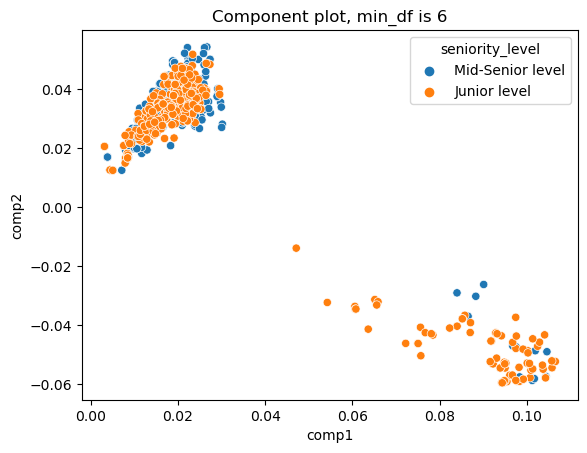

dimensions are (741, 9471)


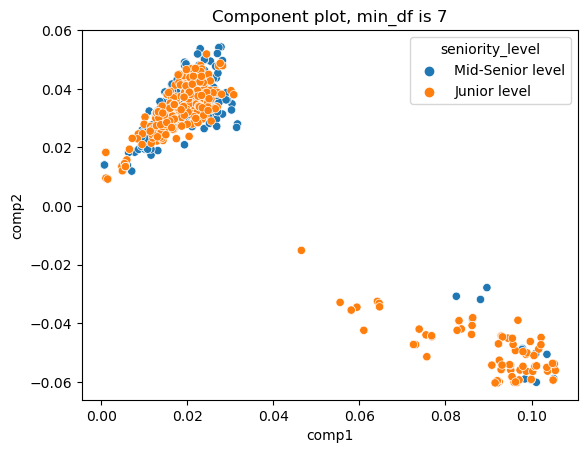

dimensions are (741, 8266)


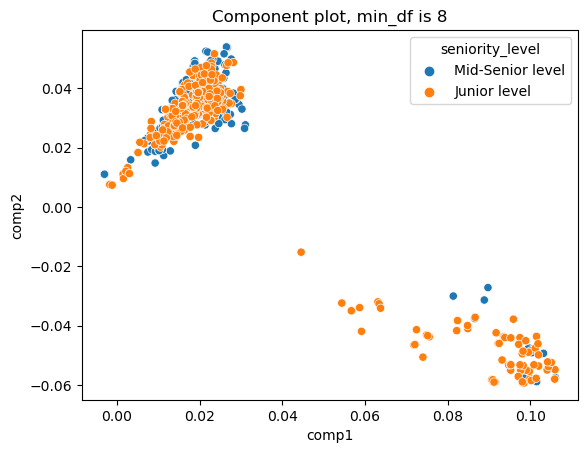

dimensions are (741, 7426)


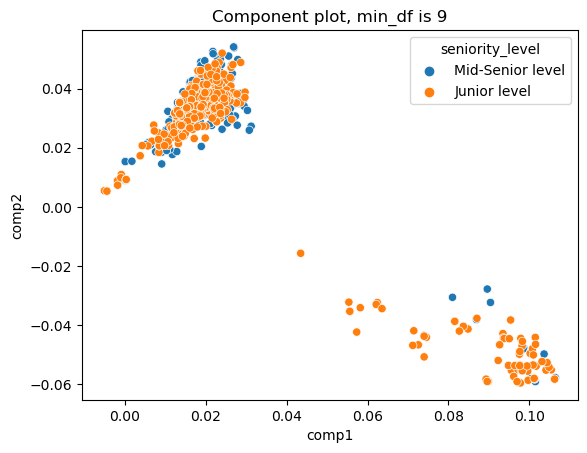

In [6]:
for i in min_df_list:
    #for j in max_df_list:
    to_be_named(i)        

In [7]:
# Fitting and transforming the vacancy texts with TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', sublinear_tf = True, ngram_range = (1,2), norm = 'l2', min_df = 4)
features = vectorizer.fit_transform(df.desc_clean).toarray()

# Splitting 'features' and the dependent variable (df.seniority_level) into a train and test set
X_train, X_test, y_train, y_test = train_test_split(
    features, df.seniority_level, train_size=500, random_state=862025)

In [14]:
# For loop to look at explained variance and performance of computed components
components_SVD = [50, 60, 70, 80, 90, 100]
variance_ratio_list = []

for component in components_SVD:
    begin_hier = time()
    svd = TruncatedSVD(n_components = component, algorithm = 'arpack')   
    features_reduced = svd.fit_transform(X_train)
    end_hier = time()
    tijd = end_hier - begin_hier

    variance_ratio_list.append([component, svd.explained_variance_ratio_.sum(), tijd])

SVD_Results = pd.DataFrame(variance_ratio_list, columns=['Components', 'ExplainedVar', 'Time (sec)'])
SVD_Results

,Components,ExplainedVar,Time (sec)
0,50,0.376097,64.642336
1,60,0.415113,62.793626
2,70,0.450163,63.782465
3,80,0.481296,80.421590
4,90,0.509805,92.600896
5,100,0.536435,107.280469


In [8]:
%%markdown
Similar to the first version of the model, the trained SVD with 70 components maintains the balance between 
a relatively high explained variance and a relatively low time to train. Also, the explained variance for a SVD 
with 70 components is higher than the explained variance when the `Tfidfvectorizer` had a value for `max_df` (0.45 to 0.41). 


Similar to the first version of the model, the trained SVD with 70 components maintains the balance between 
a relatively high explained variance and a relatively low time to train. Also, the explained variance for a SVD 
with 70 components is higher than the explained variance when the `Tfidfvectorizer` had a value for `max_df` (0.45 to 0.41). 


In [9]:
# The final SVD with 70 components
svd = TruncatedSVD(n_components = 70, algorithm = 'arpack')
X_train_svd = svd.fit_transform(X_train)

In [10]:
%%markdown
# Iteration 2
### Model training and evaluation
Once again I will train and test a logistic regression and a support vector machine (SVM). 
Its training steps are the same as in the notebook 'Iteration_1':
    
* Perform a grid search to find the best C parameter. 
* Do a cross validation on the best estimator of the training data. 
    * Evaluate the cross validation on accuracy and the Area Under Curve (AUC) score.

# Iteration 2
### Model training and evaluation
Once again I will train and test a logistic regression and a support vector machine (SVM). 
Its training steps are the same as in the notebook 'Iteration_1':
    
* Perform a grid search to find the best C parameter. 
* Do a cross validation on the best estimator of the training data. 
    * Evaluate the cross validation on accuracy and the Area Under Curve (AUC) score.


In [11]:
# Grid search on logistic regression
C_grid = np.linspace(0.01,5,10)
parameters = {'C': C_grid}

Logit_grid = LogisticRegression()
Log_gs_cv = GridSearchCV(Logit_grid, parameters).fit(X_train_svd, y_train)

cv_log_model = cross_validate(Log_gs_cv.best_estimator_, X_train_svd, y_train, 
                              cv = 3, scoring = ('accuracy', 'roc_auc'))

cv_log_model

{'fit_time': array([0.20338416, 0.1999402 , 0.29824781]),
 'score_time': array([0.19922256, 0.1029911 , 0.29578161]),
 'test_accuracy': array([0.73053892, 0.62275449, 0.64457831]),
 'test_roc_auc': array([0.80149168, 0.69234079, 0.73094789])}

In [12]:
Log_gs_cv.best_estimator_

LogisticRegression(C=3.8911111111111114)

In [13]:
# Grid search on support vector machine
C_grid = np.linspace(0.01,5,10)
kernel_grid = ['rbf', 'linear'] 
parameters = {'C': C_grid, 'kernel': kernel_grid}

SVM_grid = SVC(probability= True)
Svm_gs_cv = GridSearchCV(SVM_grid, parameters).fit(X_train_svd, y_train)

cv_svm_model = cross_validate(Svm_gs_cv.best_estimator_, X_train_svd, y_train, 
                              cv = 3, scoring = ('accuracy', 'roc_auc'))

cv_svm_model

{'fit_time': array([0.09919286, 0.09851122, 0.09390283]),
 'score_time': array([0.00575399, 0.00519466, 0.00555277]),
 'test_accuracy': array([0.71856287, 0.60479042, 0.65662651]),
 'test_roc_auc': array([0.78757889, 0.6840218 , 0.71998839])}

In [14]:
Svm_gs_cv.best_estimator_

SVC(C=3.336666666666667, kernel='linear', probability=True)

In [15]:
# Empty dataframe to store the results
Results_trainset = pd.DataFrame(columns = ['train_accuracy','train_auc', 'fit_time', 'score_time'])

In [16]:
# Function to fill empty dataframe with training results
def record_results(cv_model, model_name):
    """
    cv_model = cross_validate(be, X_train, y_train, 
                              cv = 3, scoring = ('accuracy', 'roc_auc'))
    """
    accuracy_score = np.mean(cv_model['test_accuracy'])
    auc_score = np.mean(cv_model['test_roc_auc'])
    fit_time = np.mean(cv_model['fit_time'])
    score_time = np.mean(cv_model['score_time'])
    
    Results_trainset.loc[model_name] = pd.Series({'train_accuracy': accuracy_score, 
                                                   'train_auc': auc_score,
                                                   'fit_time': fit_time, 
                                                   'score_time': score_time})


record_results(cv_log_model, 'Logit')
record_results(cv_svm_model, 'SVM')

In [17]:
%%markdown
##### Evaluation
Again, the training results of the logistic regression and support vector machine are similar (as measured by accuracy and the AUC), albeit slighty better than 
the first attempt (See notebook 'Iteration_1').  

##### Evaluation
Again, the training results of the logistic regression and support vector machine are similar (as measured by accuracy and the AUC), albeit slighty better than 
the first attempt (See notebook 'Iteration_1').  


In [18]:
Results_trainset

,train_accuracy,train_auc,fit_time,score_time
Logit,0.665957,0.741593,0.233857,0.199332
SVM,0.659993,0.730530,0.097202,0.005500


In [29]:
Results_trainset.to_csv('Train_results_att2.csv', index= False)

In [19]:
%%markdown
### Test results
##### Accuracy
The accuracy for the logistic regression is 0.5228. This is not great but still an improvement from the 0.5021 of the first version of the logistic regression.
For the support vector machine the accuracy is 0.5519, a better score than the logistic regression but also better than the SVM of the first iteration (0.5021). 
Again, the absolute value is not great but the improvement in accuracy is promising.    

##### AUC
Like with the accuracy metric, the AUC results show markedly improvements. The AUC score for the logistic regression is 0.57, up from 0.48 from the first iteration.
For the SVM the score is 0.59, against 0.51 in the first iteration.
While keeping in mind that on a scale of 0.5 to 1 the scores are still not great, this progress is encouraging. It is also visible in the plots of the ROC curves, 
the orange line is more of curve and visibly above the diagonal blue line. 



### Test results
##### Accuracy
The accuracy for the logistic regression is 0.5228. This is not great but still an improvement from the 0.5021 of the first version of the logistic regression.
For the support vector machine the accuracy is 0.5519, a better score than the logistic regression but also better than the SVM of the first iteration (0.5021). 
Again, the absolute value is not great but the improvement in accuracy is promising.    

##### AUC
Like with the accuracy metric, the AUC results show markedly improvements. The AUC score for the logistic regression is 0.57, up from 0.48 from the first iteration.
For the SVM the score is 0.59, against 0.51 in the first iteration.
While keeping in mind that on a scale of 0.5 to 1 the scores are still not great, this progress is encouraging. It is also visible in the plots of the ROC curves, 
the orange line is more of curve and visibly above the diagonal blue line. 



In [20]:
def roc_plot(prob, model):
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(recode_y_test, prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve: {}'.format(model))
    plt.legend(loc="lower right")
    plt.show()

    print("The AUC score is {}".format(round(roc_auc,4)))

In [21]:
#svd = TruncatedSVD(n_components = 70, algorithm = 'arpack')
X_test_svd = svd.fit_transform(X_test)
X_test_svd

array([[ 2.10485235e-01, -1.76139646e-01, -5.38893654e-02, ...,
        -8.80267087e-02, -2.92898640e-02,  1.69248735e-02],
       [ 2.29916727e-01, -9.21062661e-02,  2.66923781e-05, ...,
        -2.43130569e-02, -4.16939803e-02,  5.26118539e-02],
       [ 1.53425276e-01, -9.97801799e-02, -2.63265850e-02, ...,
         2.62622899e-02,  1.60745542e-01,  2.71548757e-02],
       ...,
       [ 2.10970185e-01, -1.18293342e-01, -1.93582724e-02, ...,
        -7.85325266e-02,  2.13718213e-01, -1.38655721e-01],
       [ 1.20211957e-01, -1.03783861e-01, -3.96497491e-02, ...,
         3.39181363e-03, -1.21830954e-01, -3.66671929e-02],
       [ 1.71137402e-01, -8.87339077e-02, -2.38302715e-02, ...,
         1.12839202e-01, -7.22973028e-02, -1.19167816e-01]])

In [22]:
recode_map = {'Mid-Senior level': 1, 'Junior level': 0}
recode_y_test = pd.Series(y_test).replace(recode_map).astype(int)

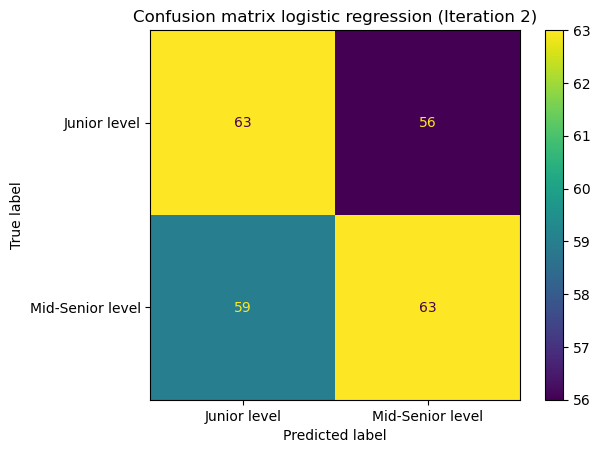

The accuracy score is 0.5228


In [23]:
logit_predictions = Log_gs_cv.best_estimator_.predict(X_test_svd)
logit_accuracy = accuracy_score(y_test, logit_predictions)

cm = confusion_matrix(y_test, logit_predictions, labels= Log_gs_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Log_gs_cv.classes_)
disp.plot()
plt.title('Confusion matrix logistic regression (Iteration 2)')
plt.show()
print("The accuracy score is {}".format(round(logit_accuracy,4)))

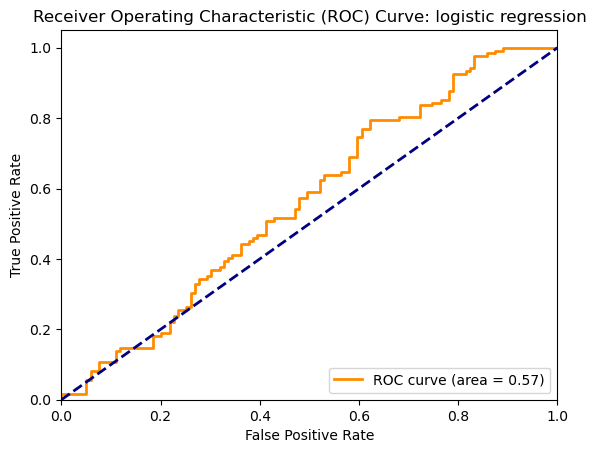

The AUC score is 0.5652


In [24]:
logit_predictions_proba = Log_gs_cv.best_estimator_.predict_proba(X_test_svd)
roc_plot(logit_predictions_proba[:, 1],'logistic regression')

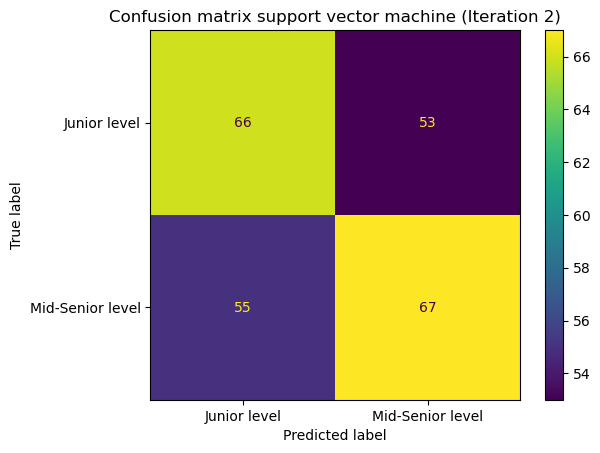

The accuracy score is 0.5519


In [25]:
svm_predictions = Svm_gs_cv.best_estimator_.predict(X_test_svd)
svm_accuracy = accuracy_score(y_test, svm_predictions)

cm = confusion_matrix(y_test, svm_predictions, labels= Svm_gs_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Svm_gs_cv.classes_)
disp.plot()
plt.title('Confusion matrix support vector machine (Iteration 2)')
plt.show()

print("The accuracy score is {}".format(round(svm_accuracy,4)))

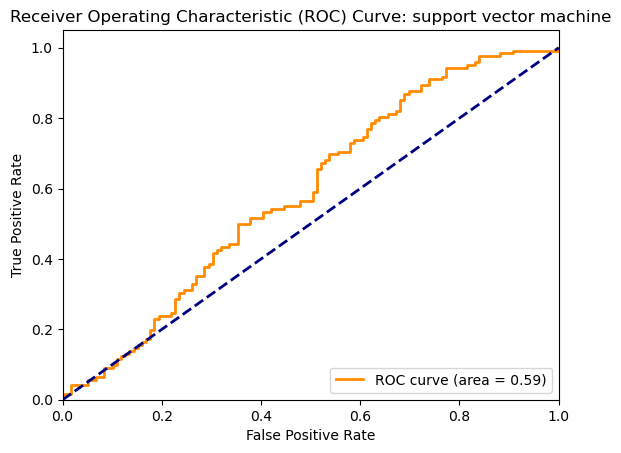

The AUC score is 0.5886


In [26]:
Svm_predictions_proba = Svm_gs_cv.best_estimator_.predict_proba(X_test_svd)
roc_plot(Svm_predictions_proba[:, 1],'support vector machine')